In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from collections import OrderedDict
import math
import argparse
import pickle
import saving_utils
import utils_MNIST
from torchvision.models.feature_extraction import get_graph_node_names,create_feature_extractor
from sklearn import  linear_model
from sklearn.metrics import r2_score

import os
import imageio

In [2]:
def custom_MSE_Loss(outputs, targets):
    batch_size = len(targets)
    delta = outputs-targets
    delta = delta**2
    loss = torch.sum(delta)/batch_size
    if loss < 1e-8:
        loss=0.
    return loss

In [3]:
teacher_depth=2
teacher_width=2
trainset_size=1000
testset_size=1000
input_dim=2
sample_size=trainset_size+testset_size
with torch.no_grad():
    teacher=utils_MNIST.fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
    inputs=torch.normal(0,1,(sample_size,round(input_dim)))
    outputs=teacher(inputs)

train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], outputs[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], outputs[trainset_size:], input_dim)

In [264]:
#print(inputs)
#print(outputs)
print(teacher.state_dict())


OrderedDict([('linear_body.0.weight', tensor([[ 0.3109,  0.6719],
        [ 0.4807, -0.1572]])), ('linear_body.0.bias', tensor([0.8058, 0.1950])), ('linear_out.weight', tensor([[0.1795, 0.9344]])), ('linear_out.bias', tensor([-0.8400]))])


In [12]:
help_tensor=torch.randint(0,2,(2,2))
help_tensor*=2
help_tensor-=1
help_tensor1=torch.randint(0,2,(1,2))
help_tensor1*=2
help_tensor1-=1
print(help_tensor1)

tensor([[ 1, -1]])


In [13]:
teacher.state_dict()['linear_body.0.weight']=help_tensor
teacher.state_dict()['linear_body.0.bias']=help_tensor1

In [5]:
width=2
depth=2
#criterion=nn.MSELoss()
criterion=nn.MSELoss(reduction='mean')
#criterion=custom_MSE_Loss()
learning_rate=1e-5
weight_decay=0.
epochs=500
batch_size=10
student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
student.load_state_dict(teacher.state_dict())

optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
#optimizer = optim.Adam(student.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-8)
trainloader=torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=2)
testloader=torch.utils.data.DataLoader(test_set, batch_size=len(test_set),shuffle=False, num_workers=2)

In [ ]:
original_dict=teacher.state_dict()
for i in teacher.state_dict().keys():
    tensor=original_dict[i]
    tensor+=torch.normal(0,0.001,tensor.size())
    teacher.state_dict()[i]=tensor

In [267]:
#print(teacher.state_dict())
#print(student.state_dict())

In [268]:
for epoch in range(epochs):
    epoch+=1
    running_loss=0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=student(inputs)
        #print(outputs)
        loss=criterion(outputs.to(torch.float32), labels.to(torch.float32))
        #loss = custom_MSE_Loss(outputs.to(torch.float32), labels.to(torch.float32))
        #print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #print(loss.item())
    scheduler.step()
    print(f'Epoch:' , epoch ,np.sqrt(running_loss)/np.sqrt(trainset_size))

Epoch: 1 0.0009080293969958111
Epoch: 2 0.000860012361290883
Epoch: 3 0.0008143032789697961
Epoch: 4 0.0007708547215023077
Epoch: 5 0.000730141352507469
Epoch: 6 0.0006915162642079087
Epoch: 7 0.0006548228096891503
Epoch: 8 0.0006205820879699952
Epoch: 9 0.0005881042578407677
Epoch: 10 0.0005572575531911712
Epoch: 11 0.0005287071640122822
Epoch: 12 0.0005014019610458867
Epoch: 13 0.0004751698800894221
Epoch: 14 0.00045069587039098935
Epoch: 15 0.0004280382338346558
Epoch: 16 0.00040637015222101495
Epoch: 17 0.00038574051226514516
Epoch: 18 0.00036633386712461494
Epoch: 19 0.00034878129365322933
Epoch: 20 0.00033245595506913484
Epoch: 21 0.0003169925071672604
Epoch: 22 0.0003020757772640661
Epoch: 23 0.0002877661037206655
Epoch: 24 0.000274313702159381
Epoch: 25 0.00026217255376982483
Epoch: 26 0.00025112019465795715
Epoch: 27 0.00024060271240025795
Epoch: 28 0.00023057474069761123
Epoch: 29 0.00022093936977229128
Epoch: 30 0.00021178408554068382
Epoch: 31 0.00020308064486905395
Epoch: 

Epoch: 249 9.939457783751409e-05
Epoch: 250 9.939338404985536e-05
Epoch: 251 9.939232626412309e-05
Epoch: 252 9.939119623595144e-05
Epoch: 253 9.939075228513781e-05
Epoch: 254 9.938956427802007e-05
Epoch: 255 9.938760823807085e-05
Epoch: 256 9.938629004038886e-05
Epoch: 257 9.938467410596362e-05
Epoch: 258 9.938436994237859e-05
Epoch: 259 9.938206481060127e-05
Epoch: 260 9.938012521939568e-05
Epoch: 261 9.937832856114729e-05
Epoch: 262 9.937622878122705e-05
Epoch: 263 9.937527379219709e-05
Epoch: 264 9.937357843637662e-05
Epoch: 265 9.937287823094983e-05
Epoch: 266 9.937175637434297e-05
Epoch: 267 9.937175632071535e-05
Epoch: 268 9.937153910181407e-05
Epoch: 269 9.93696689242296e-05
Epoch: 270 9.936527709784075e-05
Epoch: 271 9.936538005164954e-05
Epoch: 272 9.936437466086207e-05
Epoch: 273 9.936437487985778e-05
Epoch: 274 9.936437508097628e-05
Epoch: 275 9.936437485751128e-05
Epoch: 276 9.936437511673069e-05
Epoch: 277 9.936412305682496e-05
Epoch: 278 9.936257310541336e-05
Epoch: 279 

Epoch: 498 9.935801003066036e-05
Epoch: 499 9.935801001278202e-05
Epoch: 500 9.935801018262631e-05


In [269]:
print(teacher.state_dict())
print(student.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.3117,  0.6741],
        [ 0.4811, -0.1574]])), ('linear_body.0.bias', tensor([0.8030, 0.1952])), ('linear_out.weight', tensor([[0.1806, 0.9354]])), ('linear_out.bias', tensor([-0.8384]))])
OrderedDict([('linear_body.0.weight', tensor([[ 0.3117,  0.6741],
        [ 0.4805, -0.1573]])), ('linear_body.0.bias', tensor([0.8029, 0.1946])), ('linear_out.weight', tensor([[0.1794, 0.9350]])), ('linear_out.bias', tensor([-0.8394]))])


In [246]:
with torch.no_grad():
    for i,data in enumerate(trainloader,0):
        if i==0:
            inputs, labels = data
            outputs=student(inputs)
            print(labels)
            print(outputs)

tensor([[-0.9566],
        [-0.9566],
        [-0.9566],
        [-0.6560],
        [-0.6910],
        [-0.8291],
        [-1.6807],
        [-0.7271],
        [-0.9566],
        [-0.9566]])
tensor([[-0.9568],
        [-0.9568],
        [-0.9568],
        [-0.6565],
        [-0.6910],
        [-0.8294],
        [-1.6807],
        [-0.7277],
        [-0.9568],
        [-0.9568]])


In [184]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = student(images.float())
nodes,_=get_graph_node_names(student)

In [185]:
features={nodes[-2]:'out'}

In [174]:
feature_extractor=create_feature_extractor(student,return_nodes=features)

In [175]:
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = feature_extractor(images.float())

In [176]:
X=outputs['out']
print(type(X))

<class 'torch.Tensor'>


In [177]:
print(X[0])

tensor([0.5486, 0.0000, 0.0000, 0.8364, 1.2676, 0.5704, 1.0783, 0.0000, 0.0000,
        0.0000, 1.6774, 0.1708, 0.0000, 0.0000, 0.6846, 0.4367, 0.9493, 0.0000,
        0.4251, 0.0000, 0.0000, 0.0000, 0.0000, 0.1024, 1.7553, 0.3958, 0.0000,
        1.2868, 0.4578, 0.6191, 0.0000, 0.7900, 1.0082, 0.1959, 1.0773, 0.0000,
        0.9049, 0.4653, 0.5695, 0.5181, 0.0000, 0.0000, 0.0000, 0.6170, 0.0000,
        0.0000, 0.9349, 0.5410, 0.5559, 0.0000, 0.0000, 0.5168, 0.2604, 0.6161,
        0.0000, 0.0000, 1.4084, 0.7717, 0.1281, 0.0000, 0.0000, 0.0000, 0.7205,
        0.0000])


In [178]:
X_check=X.numpy()
count=0
for j in range(len(X_check)):
    for i in range(len(X_check[0])):
        if X_check[j][i]==0:
            count+=1
print(count/len(X_check))

30.136


In [179]:
### fit on full layer from chunks

# chunk sizes
#css = [1, 2, 4, 8, 16, 32, 64, 100]
css=[1,2,4,8,12,16,24,32,64]

# number of repetitions
nreps = 5

# initialised matrices of residuals and covariances
rsqs = np.zeros((len(css), nreps))
diag_covs = np.zeros((len(css), width, nreps))
covs = np.zeros((len(css), width, width, nreps))

for i, cs in enumerate(css):
    print(cs)

    for r in range(nreps):
    
        indices = np.random.choice(np.arange(width), (cs), replace = False)
        Xc = X[:, indices]
        
        lm = linear_model.LinearRegression()
        lm = linear_model.Ridge(1e-8)
        
        lm.fit(Xc, X)
        X_pred = lm.predict(Xc)
        
        res = (X - X_pred)
        cov = np.cov(res.T)
        diag_covs[i, :, r] = np.diag(cov)
        
        rsqs[i, r]= r2_score(X, X_pred, multioutput = 'variance_weighted')
        covs[i,:, :, r] = cov

1
2
4
8
12
16
24
32


In [180]:
def hm_diagonal(corr):
    nondiag_entries = corr[np.tril_indices_from(corr, k = -1)]
    return np.mean(abs(nondiag_entries))

In [15]:
# compute regolarised correlation of residuals
reg = 1e-10
corrs = covs/(np.sqrt((diag_covs[:, :, None, :]*diag_covs[:, None, :, :]))+reg)

mean_non_diag_abs_corr = np.zeros((corrs.shape[0], corrs.shape[3]))

for i in range(corrs.shape[0]):
    for j in range(corrs.shape[3]):
        mean_non_diag_abs_corr[i, j] = hm_diagonal(corrs[i, :, :, j])

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

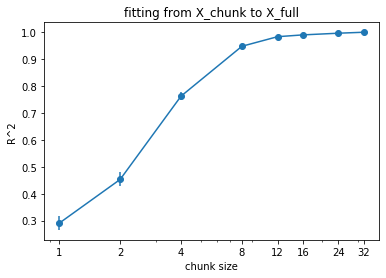

In [16]:
# plot R^2 value
plt.figure()
plt.errorbar(css, rsqs.mean(axis = 1)
             , rsqs.std(axis = 1)/np.sqrt(50), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('R^2')
plt.title('fitting from X_chunk to X_full')

Text(0.5, 1.0, 'fitting from X_chunk to X_full')

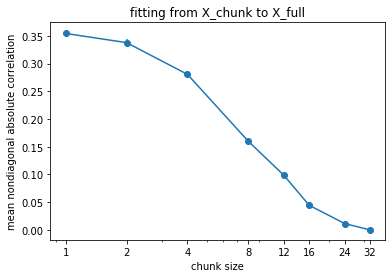

In [17]:
# plot mean nondiagonal absolute correlation
plt.figure()
plt.errorbar(css, mean_non_diag_abs_corr.mean(axis = 1)
             , mean_non_diag_abs_corr.std(axis = 1)/np.sqrt(25), marker = 'o');
plt.xscale('log');
plt.xticks(css, css);
plt.xlabel('chunk size')
plt.ylabel('mean nondiagonal absolute correlation')
plt.title('fitting from X_chunk to X_full')

# Online learning

In [2]:
class fully_connected_new(nn.Module):
    def __init__(self, widths, depth = 6, input_size = 784, output_size = 1, orthog_init = False,
            dropout = False, batch_norm = False,gaussian_init=False, p =0.5,gaussian_std=0.5,bias=True):
        super(fully_connected_new, self).__init__()

        if isinstance(widths, int):
            widths = np.array([input_size]+[widths for i in range(depth -1)], dtype = 'int')
        elif isinstance(widths, list):
            widths = np.array([input_size]+widths, dtype = 'int')
        else: raise TypeError('expected type int or list of variable widths')
        self.linear_body = make_layers_new(widths, batch_norm, dropout, p=p,bias=bias)
        self.linear_out = nn.Linear(widths[-1], output_size,bias=bias)
        if orthog_init: self.orthog_init()
        if gaussian_init:
            self.gaussian_std=gaussian_std
            self.gaussian_init()
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                #nn.init.constant_(m.weight, 1) in resnet: (and by default!!!!)
                #incredible increase in performance if m.weight is set to random uniform 0,1 from constant 1
                if gaussian_init==True:
                    nn.init.normal_(m.weight)
                    #nn.init.normal_(m.bias)
                else:
                    nn.init.uniform_(m.weight)
                    #nn.init.zeros_(m.bias)
                #nn.init.zeros_(m.running_mean)
                #nn.init.ones_(m.running_var)
            # elif isinstance(m, nn.Linear):
            #     nn.init.kaiming_normal_(m.weight) #by default is kaiming_uniform
                #nn.init.zeros_(m.bias) #by default is uniform(fan_in**0.5)

    def orthog_init(self):
        self.apply(self.init_weights_orthog)

    def gaussian_init(self):
        self.apply(self.init_weights_normal)

    def init_weights_normal(self,m):
        if type(m)==nn.Linear:
            nn.init.normal_(m.weight,0,self.gaussian_std)
            #nn.init.normal_(m.bias,0,self.gaussian_std)

    def init_weights_orthog(self, m):
        if type(m) == nn.Linear:
            nn.init.orthogonal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear_body(x)
        x = self.linear_out(x)
        return x



def make_layers_new(widths, batch_norm, dropout, p,bias):

    layers = []

    if dropout and batch_norm:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.BatchNorm1d(widths[i+1]), nn.ReLU(inplace = True), nn.Dropout(p=p)])

    elif dropout and not batch_norm:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.ReLU(inplace = True), nn.Dropout(p = p)])

    elif batch_norm and not dropout:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.BatchNorm1d(widths[i+1]), nn.ReLU(inplace = True) ])
    else:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.ReLU(inplace=True)])

    return nn.Sequential(*layers)

Initialize teacher:

In [3]:
teacher_depth=2
teacher_width=5
batch_size=1
input_dim=2
teacher=fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                            dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True,bias=False)
help_tensor=torch.randint(0,2,(2,2))
help_tensor*=2
help_tensor-=1
help_tensor1=torch.randint(0,2,(1,2))
help_tensor1*=2
help_tensor1-=1
#print(help_tensor1)
#teacher.state_dict()['linear_body.0.weight']=help_tensor
#teacher.state_dict()['linear_body.0.bias']=help_tensor1

In [4]:
torch.save(teacher.state_dict(),f'./gifs/teacher_width_5_input_2.pth')

In [5]:
plot_weights(teacher,student,0,filenames,True)

NameError: name 'plot_weights' is not defined

Initialize student:

In [210]:
width=20
depth=2
#criterion=nn.MSELoss()
criterion=nn.MSELoss(reduction='mean')
#criterion=custom_MSE_Loss()
learning_rate=5e-2
weight_decay=0.
student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.0, weight_decay=weight_decay)
#optimizer = optim.Adam(student.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-8)



In [169]:
print(teacher.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.1707, -0.9774],
        [-0.4731,  0.3230],
        [-0.0959,  0.5678],
        [ 0.7951,  0.3049],
        [ 0.4346, -0.3717]])), ('linear_out.weight', tensor([[ 0.2802, -0.1411, -0.7722,  0.3506, -0.6727]]))])


In [170]:
#if you want, you can have the student start as a copy of the teacher and then add some noise
seq=torch.randint(0,teacher_width,(1,width))
print(seq)
for i in range(len(student.state_dict()['linear_body.0.weight'])):
    student.state_dict()['linear_body.0.weight'][i]=teacher.state_dict()['linear_body.0.weight'][seq[0][i]]
    #student.state_dict()['linear_body.0.bias'][i]=teacher.state_dict()['linear_body.0.bias'][seq[0][i]]
    student.state_dict()['linear_out.weight'][0][i]=teacher.state_dict()['linear_out.weight'][0][seq[0][i]]
#student.state_dict()['linear_out.bias']=teacher.state_dict()['linear_out.bias']*width/teacher_width
#print(teacher.state_dict())
#print(student.state_dict())

tensor([[2, 4, 1, 1, 3, 4, 4, 3, 2, 4, 2, 0, 3, 1, 2, 0, 3, 0, 4, 1]])


In [171]:
#add noise
print(type(teacher.state_dict()))
original_dict=student.state_dict()
for i in teacher.state_dict().keys():
    tensor=original_dict[i]
    tensor+=torch.normal(0,0.1,tensor.size())
    student.state_dict()[i]=tensor
#print(student.state_dict())

<class 'collections.OrderedDict'>


In [208]:
os.mkdir('temporary')
def plot_weights(teacher,student,time,filenames,show):
    student_weights=student.state_dict()['linear_body.0.weight']
    student_out=student.state_dict()['linear_out.weight']

    for_printing=torch.empty(width,input_dim)

    for i in range(len(student_weights)):
        for_printing[i]=student_weights[i]*torch.abs(student_out)[0][i].item()
    #print(for_printing)

    teacher_weights=teacher.state_dict()['linear_body.0.weight']
    #print(teacher_weights)
    teacher_out=teacher.state_dict()['linear_out.weight']

    for_printing_t=torch.empty(teacher_width,input_dim)

    for i in range(len(teacher_weights)):
        for_printing_t[i]=teacher_weights[i]*torch.abs(teacher_out)[0][i].item()

    for_printing=torch.transpose(for_printing,0,1)
    for_printing_t=torch.transpose(for_printing_t,0,1)
    plt.scatter(for_printing_t[0],for_printing_t[1],color='red')
    plt.scatter(for_printing[0], for_printing[1])
    #figure(figsize=(8, 6), dpi=80)
    plt.rcParams["figure.figsize"]=(16,12)
    plt.xlim((-0.5,0.5))
    plt.ylim((-0.5,0.5))
    #print(for_printing_t)

    for i in range(len(teacher_weights)):
        plt.plot([0,for_printing_t[0][i]],[0,for_printing_t[1][i]],'--r')
    plt.savefig(f'temporary/Epoch{time}.png')
    if show==True:
        plt.show()
    plt.close()
    filenames.append(f'temporary/Epoch{time}.png')

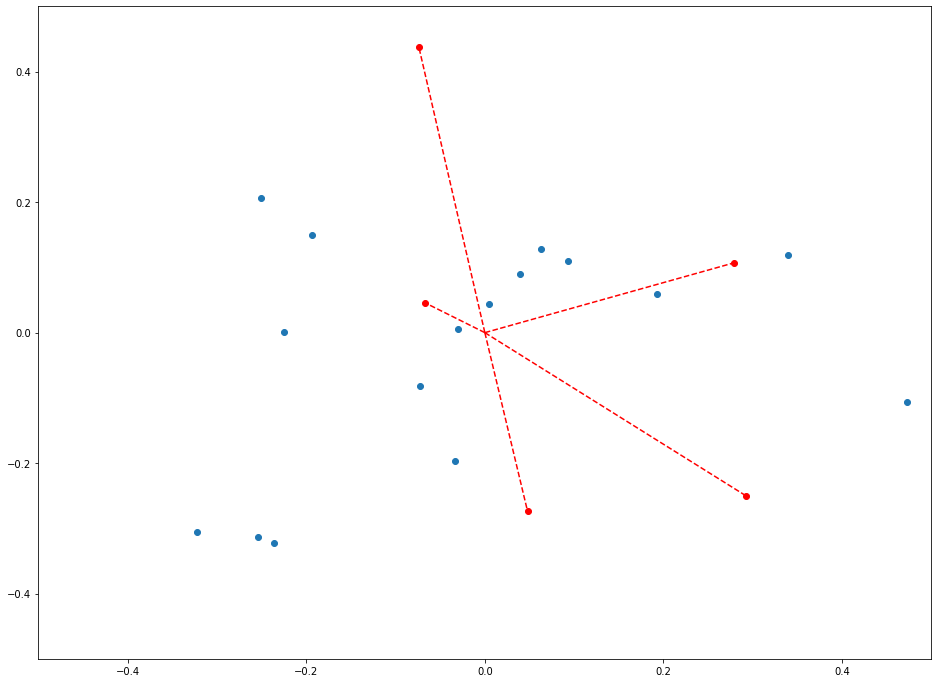

In [211]:
filenames=[]
plot_weights(teacher,student,0,filenames,True)

In [212]:
epochs=1000000
running_loss=0.
for epoch in range(epochs):
    epoch+=1
    #if epoch==round(epochs/2):
        #optimizer = optim.SGD(student.parameters(), lr=learning_rate/10,momentum=0.0, weight_decay=weight_decay)
    with torch.no_grad():
        inputs=torch.normal(0,1,(batch_size,round(input_dim)))
        outputs=teacher(inputs)
    batch_set = utils_MNIST.CustomDataSet(inputs, outputs, input_dim)
    batchloader=torch.utils.data.DataLoader(batch_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=2)
    for i, data in enumerate(batchloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=student(inputs)
        #print(outputs)
        loss=criterion(outputs.to(torch.float32), labels.to(torch.float32))
        #loss = custom_MSE_Loss(outputs.to(torch.float32), labels.to(torch.float32))
        #print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #print(loss.item())
    scheduler.step()
    if epoch%round(epochs/100)==0:
        print(f'Epoch:' , epoch ,np.sqrt(running_loss)/np.sqrt(batch_size))
        plot_weights(teacher,student,epoch,filenames,False)
        running_loss=0

Epoch: 1 2.4347348301061715
Epoch: 2 1.7675051510747932
Epoch: 3 0.6208727461403599
Epoch: 4 2.129543272131863
Epoch: 5 1.3090093152098703
Epoch: 6 0.16105020312816373
Epoch: 7 0.6129330417987874
Epoch: 8 0.5631756698132976
Epoch: 9 0.14012944804081454
Epoch: 10 0.12505024406826068
Epoch: 11 0.1652054202184525
Epoch: 12 0.781301840015912
Epoch: 13 0.24320791990342933
Epoch: 14 0.22892758331878363
Epoch: 15 1.5986670395455922
Epoch: 16 0.2429588401711514
Epoch: 17 0.12974965289470058
Epoch: 18 2.211217208800309
Epoch: 19 2.4926517257501115
Epoch: 20 0.5623126512700889
Epoch: 21 0.9220683654751671
Epoch: 22 0.12041377845631164
Epoch: 23 0.18740208373814565
Epoch: 24 0.3583963586398752
Epoch: 25 0.5132166654926208
Epoch: 26 0.38399455463502263
Epoch: 27 0.09913307267890752
Epoch: 28 0.50954122463969
Epoch: 29 0.45530002734001745
Epoch: 30 0.23813265716827003
Epoch: 31 0.07179665467910253
Epoch: 32 0.24156391710899572
Epoch: 33 0.0299050807183059
Epoch: 34 1.5797517154066718
Epoch: 35 1.19

In [205]:
'''teacher_weights=teacher.state_dict()['linear_body.0.weight']
#print(teacher_weights)
teacher_weights=torch.transpose(teacher_weights,0,1)
#print(teacher_weights)
student_weights=student.state_dict()['linear_body.0.weight']
print(student_weights)
student_weights=torch.transpose(student_weights,0,1)
plt.scatter(teacher_weights[0],teacher_weights[1],color='red')
plt.scatter(student_weights[0], student_weights[1])
'''

"teacher_weights=teacher.state_dict()['linear_body.0.weight']\n#print(teacher_weights)\nteacher_weights=torch.transpose(teacher_weights,0,1)\n#print(teacher_weights)\nstudent_weights=student.state_dict()['linear_body.0.weight']\nprint(student_weights)\nstudent_weights=torch.transpose(student_weights,0,1)\nplt.scatter(teacher_weights[0],teacher_weights[1],color='red')\nplt.scatter(student_weights[0], student_weights[1])\n"

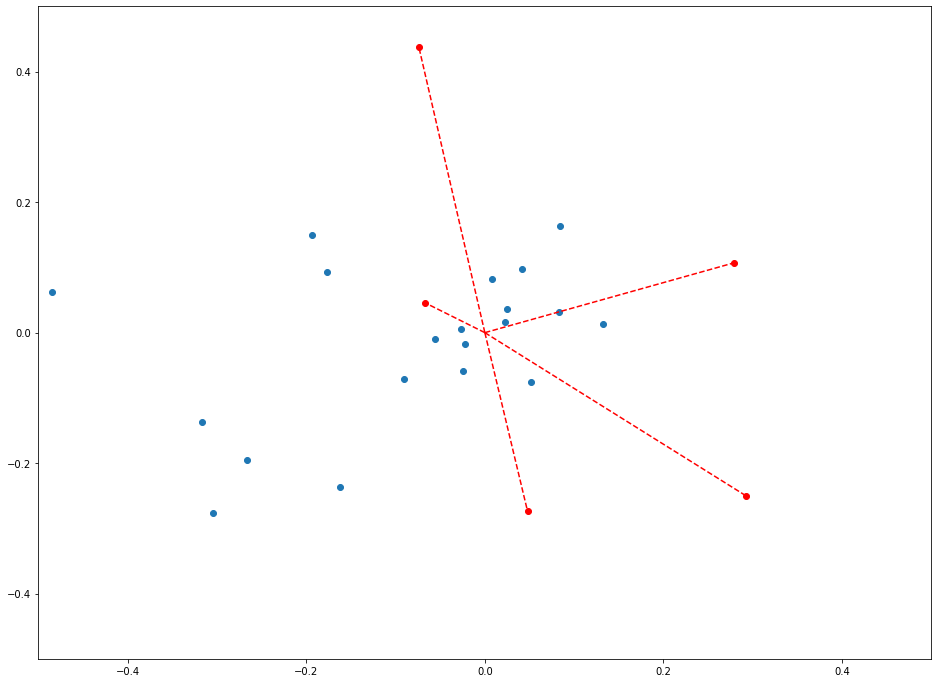

In [213]:
plot_weights(teacher,student,epochs,filenames,True)

In [214]:
# Build GIF
print('creating gif\n')
gif_name=f'{teacher_width}_{width}_{epochs}'
with imageio.get_writer(f'./gifs/{gif_name}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('gif complete\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
os.rmdir('temporary')
print('done')

creating gif

gif complete

Removing Images

done


In [50]:
filenames=[]
for i in range(20000,1000000,1000):
    filenames.append(f'./gifs/5_20_1000000/Epoch{i}.png')
    print(i)
# Build GIF
print('creating gif\n')
gif_name=f'5_20_1000000'
with imageio.get_writer(f'./gifs/{gif_name}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('gif complete\n')
#print('Removing Images\n')
# Remove files
#for filename in set(filenames):
#    os.remove(filename)
#os.rmdir('temporary')
print('done')

20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
17

FileNotFoundError: No such file: '/home/federico/Desktop/Tesi/MNIST/gifs/5_20_1000000/Epoch21000.png'

## Dynamics of SGD (Goldt et al., 2019)

In [35]:
class fully_connected_new(nn.Module):
    def __init__(self, widths, depth = 6, input_size = 784, output_size = 1, orthog_init = False,
            dropout = False, batch_norm = False,gaussian_init=False, p =0.5,gaussian_std=0.5,bias=True):
        super(fully_connected_new, self).__init__()

        if isinstance(widths, int):
            widths = np.array([input_size]+[widths for i in range(depth -1)], dtype = 'int')
        elif isinstance(widths, list):
            widths = np.array([input_size]+widths, dtype = 'int')
        else: raise TypeError('expected type int or list of variable widths')
        self.linear_body = make_layers_new(widths, batch_norm, dropout, p=p,bias=bias)
        self.linear_out = nn.Linear(widths[-1], output_size,bias=bias)
        if orthog_init: self.orthog_init()
        if gaussian_init:
            self.gaussian_std=gaussian_std
            self.gaussian_init()
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                #nn.init.constant_(m.weight, 1) in resnet: (and by default!!!!)
                #incredible increase in performance if m.weight is set to random uniform 0,1 from constant 1
                if gaussian_init==True:
                    nn.init.normal_(m.weight)
                    #nn.init.normal_(m.bias)
                else:
                    nn.init.uniform_(m.weight,-0.5,0.5)
                    #nn.init.zeros_(m.bias)
                #nn.init.zeros_(m.running_mean)
                #nn.init.ones_(m.running_var)
            # elif isinstance(m, nn.Linear):
            #     nn.init.kaiming_normal_(m.weight) #by default is kaiming_uniform
                #nn.init.zeros_(m.bias) #by default is uniform(fan_in**0.5)

    def orthog_init(self):
        self.apply(self.init_weights_orthog)
    def gaussian_init(self):
        self.apply(self.init_weights_normal)
    def init_weights_normal(self,m):
        if type(m)==nn.Linear:
            nn.init.normal_(m.weight,0,self.gaussian_std)
            #nn.init.normal_(m.bias,0,self.gaussian_std)
    def init_weights_orthog(self, m):
        if type(m) == nn.Linear:
            nn.init.orthogonal_(m.weight)
            nn.init.zeros_(m.bias)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear_body(x)
        x = self.linear_out(x)
        return x



def make_layers_new(widths, batch_norm, dropout, p,bias):
    layers = []
    if dropout and batch_norm:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.BatchNorm1d(widths[i+1]), nn.ReLU(inplace = True), nn.Dropout(p=p)])

    elif dropout and not batch_norm:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.ReLU(inplace = True), nn.Dropout(p = p)])

    elif batch_norm and not dropout:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.BatchNorm1d(widths[i+1]), nn.ReLU(inplace = True) ])
    else:
        for i in range(len(widths)-1):
            layers.extend([nn.Linear(widths[i], widths[i+1],bias=bias), nn.Tanh()])
    return nn.Sequential(*layers)

In [54]:
teacher_depth=2
teacher_width=2
batch_size=4
input_dim=2
teacher=fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                            dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True,bias=False)
sigma=0.01
#print(help_tensor1)
#teacher.state_dict()['linear_body.0.weight']=help_tensor
#teacher.state_dict()['linear_body.0.bias']=help_tensor1

In [55]:
help_tensor=torch.ones(1,2)*1
teacher.state_dict()['linear_out.weight'][0]=help_tensor

In [56]:
print(teacher.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.9891, -0.1342],
        [-0.0768,  0.7230]])), ('linear_out.weight', tensor([[1., 1.]]))])


In [73]:
width=5
depth=2
#criterion=nn.MSELoss()
criterion=nn.MSELoss(reduction='mean')
#criterion=custom_MSE_Loss()
learning_rate=0.1
weight_decay=0.
student=fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True,bias=False)
optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.0, weight_decay=weight_decay)
#optimizer = optim.Adam(student.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-8)

In [74]:
help_tensor=torch.ones(1,5)*1*2/5
student.state_dict()['linear_out.weight'][0]=help_tensor

In [75]:
print(student.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.2237,  1.1649],
        [ 0.6730,  0.1968],
        [-0.2095,  0.6031],
        [ 0.0884, -1.4528],
        [ 0.5823, -0.0770]])), ('linear_out.weight', tensor([[0.4000, 0.4000, 0.4000, 0.4000, 0.4000]]))])


In [76]:
def printing_alignment_weights(weights_tensor_1, weights_tensor_2):
    res=torch.matmul(weights_tensor_1, torch.transpose(weights_tensor_2,0,1))
    #print(res/len(weights_tensor_1[0]))
    print(torch.norm(weights_tensor_2))
    print(res/torch.norm(weights_tensor_2)*len(weights_tensor_2[0]))

In [77]:
epochs=100000
losses=[]
running_loss=0
for epoch in range(epochs):
    epoch+=1
    #if epoch==round(epochs/2):
        #optimizer = optim.SGD(student.parameters(), lr=learning_rate/10,momentum=0.0, weight_decay=weight_decay)
    with torch.no_grad():
        inputs=torch.normal(0,1,(batch_size,round(input_dim)))
        outputs=teacher(inputs)+sigma*np.random.normal(0,1)
    batch_set = utils_MNIST.CustomDataSet(inputs, outputs, input_dim)
    batchloader=torch.utils.data.DataLoader(batch_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=2)
    for i, data in enumerate(batchloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=student(inputs)
        #print(outputs)
        loss=criterion(outputs.to(torch.float32), labels.to(torch.float32))
        #loss = custom_MSE_Loss(outputs.to(torch.float32), labels.to(torch.float32))
        #print(loss)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #print(loss.item())
    #scheduler.step()
    if epoch%round(epochs/100)==0:
        print(f'Epoch:' , epoch ,np.sqrt(running_loss)/np.sqrt(batch_size)/round(epochs/100))
        losses.append(np.sqrt(running_loss)/np.sqrt(batch_size)/round(epochs/100))
        running_loss=0
        printing_alignment_weights(teacher.state_dict()['linear_body.0.weight'],student.state_dict()['linear_body.0.weight'])

Epoch: 1000 0.0006435345194888021
tensor(2.3665)
tensor([[-0.1285,  0.7999, -0.2137,  0.1933,  0.8140],
        [ 0.6673, -0.0991,  0.3911, -0.8982, -0.1879]])
Epoch: 2000 0.0001828228950537348
tensor(2.3703)
tensor([[-0.1332,  0.8116, -0.1958,  0.1889,  0.8254],
        [ 0.6610, -0.1026,  0.3812, -0.8970, -0.1871]])
Epoch: 3000 0.0001704312244700899
tensor(2.3715)
tensor([[-0.1380,  0.8154, -0.1826,  0.1846,  0.8274],
        [ 0.6616, -0.1064,  0.3792, -0.8953, -0.1871]])
Epoch: 4000 0.00017262063954204441
tensor(2.3748)
tensor([[-0.1418,  0.8199, -0.1751,  0.1814,  0.8303],
        [ 0.6627, -0.1065,  0.3768, -0.8924, -0.1811]])
Epoch: 5000 0.0001804329775540773
tensor(2.3753)
tensor([[-0.1442,  0.8235, -0.1673,  0.1789,  0.8334],
        [ 0.6624, -0.1098,  0.3742, -0.8909, -0.1793]])
Epoch: 6000 0.00017321846646437984
tensor(2.3742)
tensor([[-0.1488,  0.8233, -0.1636,  0.1766,  0.8325],
        [ 0.6642, -0.1124,  0.3751, -0.8900, -0.1777]])
Epoch: 7000 0.00016797711432614432
ten

Epoch: 52000 0.0001622281763862953
tensor(2.3515)
tensor([[-0.1627,  0.8418, -0.1476,  0.1825,  0.8459],
        [ 0.6616, -0.1373,  0.3767, -0.8780, -0.1559]])
Epoch: 53000 0.00016224846663318729
tensor(2.3521)
tensor([[-0.1617,  0.8414, -0.1496,  0.1835,  0.8454],
        [ 0.6618, -0.1368,  0.3786, -0.8775, -0.1548]])
Epoch: 54000 0.00016484788641378282
tensor(2.3497)
tensor([[-0.1616,  0.8414, -0.1462,  0.1833,  0.8453],
        [ 0.6619, -0.1379,  0.3776, -0.8779, -0.1558]])
Epoch: 55000 0.00016365023366269032
tensor(2.3503)
tensor([[-0.1607,  0.8419, -0.1446,  0.1832,  0.8457],
        [ 0.6617, -0.1373,  0.3780, -0.8775, -0.1549]])
Epoch: 56000 0.00016871741603710866
tensor(2.3493)
tensor([[-0.1623,  0.8420, -0.1464,  0.1829,  0.8460],
        [ 0.6609, -0.1365,  0.3781, -0.8778, -0.1537]])
Epoch: 57000 0.00016910807262814867
tensor(2.3485)
tensor([[-0.1622,  0.8415, -0.1446,  0.1829,  0.8453],
        [ 0.6620, -0.1381,  0.3787, -0.8774, -0.1552]])
Epoch: 58000 0.00016838728220

In [ ]:
x=np.linspace(1,epochs,num=100)
plt.plot(x,losses)
plt.xscale('log')
plt.yscale('log')

In [34]:
print(teacher.state_dict())
print(student.state_dict())

OrderedDict([('linear_body.0.weight', tensor([[ 0.8507, -0.6334],
        [ 0.6655,  0.7631]])), ('linear_out.weight', tensor([[1., 1.]]))])
OrderedDict([('linear_body.0.weight', tensor([[-0.9046,  0.4731],
        [ 0.7409,  0.9469],
        [-0.1398,  0.0653],
        [ 0.8764, -0.7144],
        [ 0.4877,  0.2191]])), ('linear_out.weight', tensor([[-0.1425,  0.6497,  0.1774,  0.7576,  0.5584]]))])


## Checking to be in the benign overfitting regime

In [2]:
widths=[25,50,100,200,400]
task="classification"

teacher_depth=2
teacher_width=8
trainset_size=1000
testset_size=10000
epochs=1

depth=2


input_dim=2
sample_size=trainset_size+testset_size
with torch.no_grad():
    teacher=utils_MNIST.fully_connected_new(teacher_width, teacher_depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
    inputs=torch.normal(0,1,(sample_size,round(input_dim)))
    if task=="classification":
        outputs=teacher(inputs)
        mean=torch.mean(outputs).item()
        std=torch.std(outputs).item()
        labels=outputs
        labels=labels-mean
        labels[labels<0]=0
        labels[labels>0]=1
        outputs=torch.squeeze(labels)
        #print(outputs)
    else:
        outputs=teacher(inputs)
        
train_set = utils_MNIST.CustomDataSet(inputs[:trainset_size], outputs[:trainset_size], input_dim)
test_set = utils_MNIST.CustomDataSet(inputs[trainset_size:], outputs[trainset_size:], input_dim)
trainloader=torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, drop_last=False, num_workers=0)
testloader=torch.utils.data.DataLoader(test_set, batch_size=len(test_set),shuffle=False, num_workers=0)
if task=='classification':
    criterion=nn.BCEWithLogitsLoss()
    #criterion=nn.BCELoss()
else:
    criterion=nn.MSELoss(reduction='mean')
    
learning_rate=5e-2


NameError: name 'batch_size' is not defined

In [3]:
outputs_dictionary=dict()
width_test_accs=[]
for W in widths:
    width_outputs=[]
    width_test_acc=0
    for i in range(3):
        student=utils_MNIST.fully_connected_new(width, depth, input_dim, output_size=1,
                                dropout=False, batch_norm=False, orthog_init=False, gaussian_init=True)
        optimizer = optim.SGD(student.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
        #optimizer = optim.Adam(student.parameters(),lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min = 10**-7)
        train_acc=0
        for epoch in range(epochs):
            if train_acc!=100:
                epoch+=1
                running_loss=0
                for i, data in enumerate(trainloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    #print(labels)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs=student(inputs)
                    outputs = torch.squeeze(outputs)
                    #print(outputs)

                    #print(labels)
                    loss = criterion(outputs.to(torch.float32), labels.to(torch.float32))
                    loss.backward()
                    optimizer.step()
                    # print statistics
                    running_loss += loss.item()
                scheduler.step()
                if epoch%10==0:    
                    train_acc,train_loss,_=utils_MNIST.evaluate_on_dataset('teacher', trainloader, student, criterion)
                    test_acc,test_loss,_=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, criterion)
                    #print(train_loss.item()/len(train_set),'    ', test_loss.item()/len(test_set))
                    print(f'Width {W}, epoch: {epoch}, train accuracy {train_acc}, test accuracy {test_acc}')
        train_acc,train_loss,_=utils_MNIST.evaluate_on_dataset('teacher', trainloader, student, criterion)
        test_acc,test_loss,test_outputs=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, criterion)
        test_outputs=torch.sigmoid(test_outputs)
        width_test_acc+=test_acc
            
        #print(test_outputs)
        width_outputs.append(test_outputs)
    outputs_dictionary[W]=width_outputs
    width_test_accs.append(width_test_acc/3.)
        

NameError: name 'width' is not defined

In [33]:
accuracy_inf=0
list_of_outputs=outputs_dictionary[widths[-1]]
ensemble_outputs=torch.zeros(len(test_set))
for element in list_of_outputs:
    ensemble_outputs=ensemble_outputs+element
ensemble_outputs=ensemble_outputs/3

In [34]:
test_acc,test_loss,_=utils_MNIST.evaluate_on_dataset('teacher', testloader, student, nn.BCEWithLogitsLoss())

In [35]:
print(test_acc)

99.63


In [36]:
print(width_test_accs)

[99.52333333333333, 99.63333333333333, 99.60333333333334, 99.56333333333333, 99.60000000000001]
